In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import uproot as up

In [5]:
branch_names=['trilep_type',
              'lep_ID_0','lep_ID_1','lep_ID_2',
              'lep_Pt_0','lep_Pt_1','lep_Pt_2',
              'lep_E_0','lep_E_1','lep_E_2','Ptll01','Ptll02','Ptll12',
              'lep_Eta_0','lep_Eta_1','lep_Eta_2',
              'lep_Phi_0','lep_Phi_1','lep_Phi_2',
              'lep_isolationPflowLoose_0','lep_isolationPflowLoose_1','lep_isolationPflowLoose_2',
              'lep_Mtrktrk_atPV_CO_0','lep_Mtrktrk_atPV_CO_1','lep_Mtrktrk_atPV_CO_2',
              'lep_RadiusCO_0','lep_RadiusCO_1','lep_RadiusCO_2',
              'met_met','Mll01','Mll02','Mll12','best_Z_Mll','minOSSFMll','minOSMll',
              'DRll01','DRll02','DRll12',
              'HT','HT_lep','HT_jets','lead_jetPt','sublead_jetPt','lead_jetE','sublead_jetE',
              'nJets_OR','nJets_OR_DL1r_85','nTaus_OR_Pt25_RNN',
              'DRl1jmin','DRl0jmin','DRjjMax',
              'DRl0j0','DRl0j1','DRl1j0','DRl1j1','DRl2j0','DRl2j1','DRj0j1',
              'mj0j1','ml0j0','ml0j1','ml1j0','ml1j1','ml2j0','ml2j1']


signal_events = up.open("hhml_signal.root")['nominal']
ttbar_events = up.open("ttbar.root")['nominal']
vv_events = up.open("vv.root")['nominal']
#print("Variables available: ",signal_events.keys())

df_signal = signal_events.pandas.df(branch_names)
df_ttbar = ttbar_events.pandas.df(branch_names)
df_vv    = vv_events.pandas.df(branch_names)


df_signal['class'] =0
df_ttbar['class'] =1
df_vv['class']=2


print("Total Signal events: ",len(df_signal))
print("Total ttbar events: ",len(df_ttbar))
print("Total VV events: ",len(df_vv))

#combine data
df_bkgrnd = df_ttbar.append(df_vv)
df = df_bkgrnd.append(df_signal)

df = df.sample(frac=1).reset_index(drop=True) # Sort 

# Separate class info from inputs (no cheating!)
y_df = df.pop('class')

Total Signal events:  25706
Total ttbar events:  7834
Total VV events:  504022


In [ ]:
#signal_events.keys()

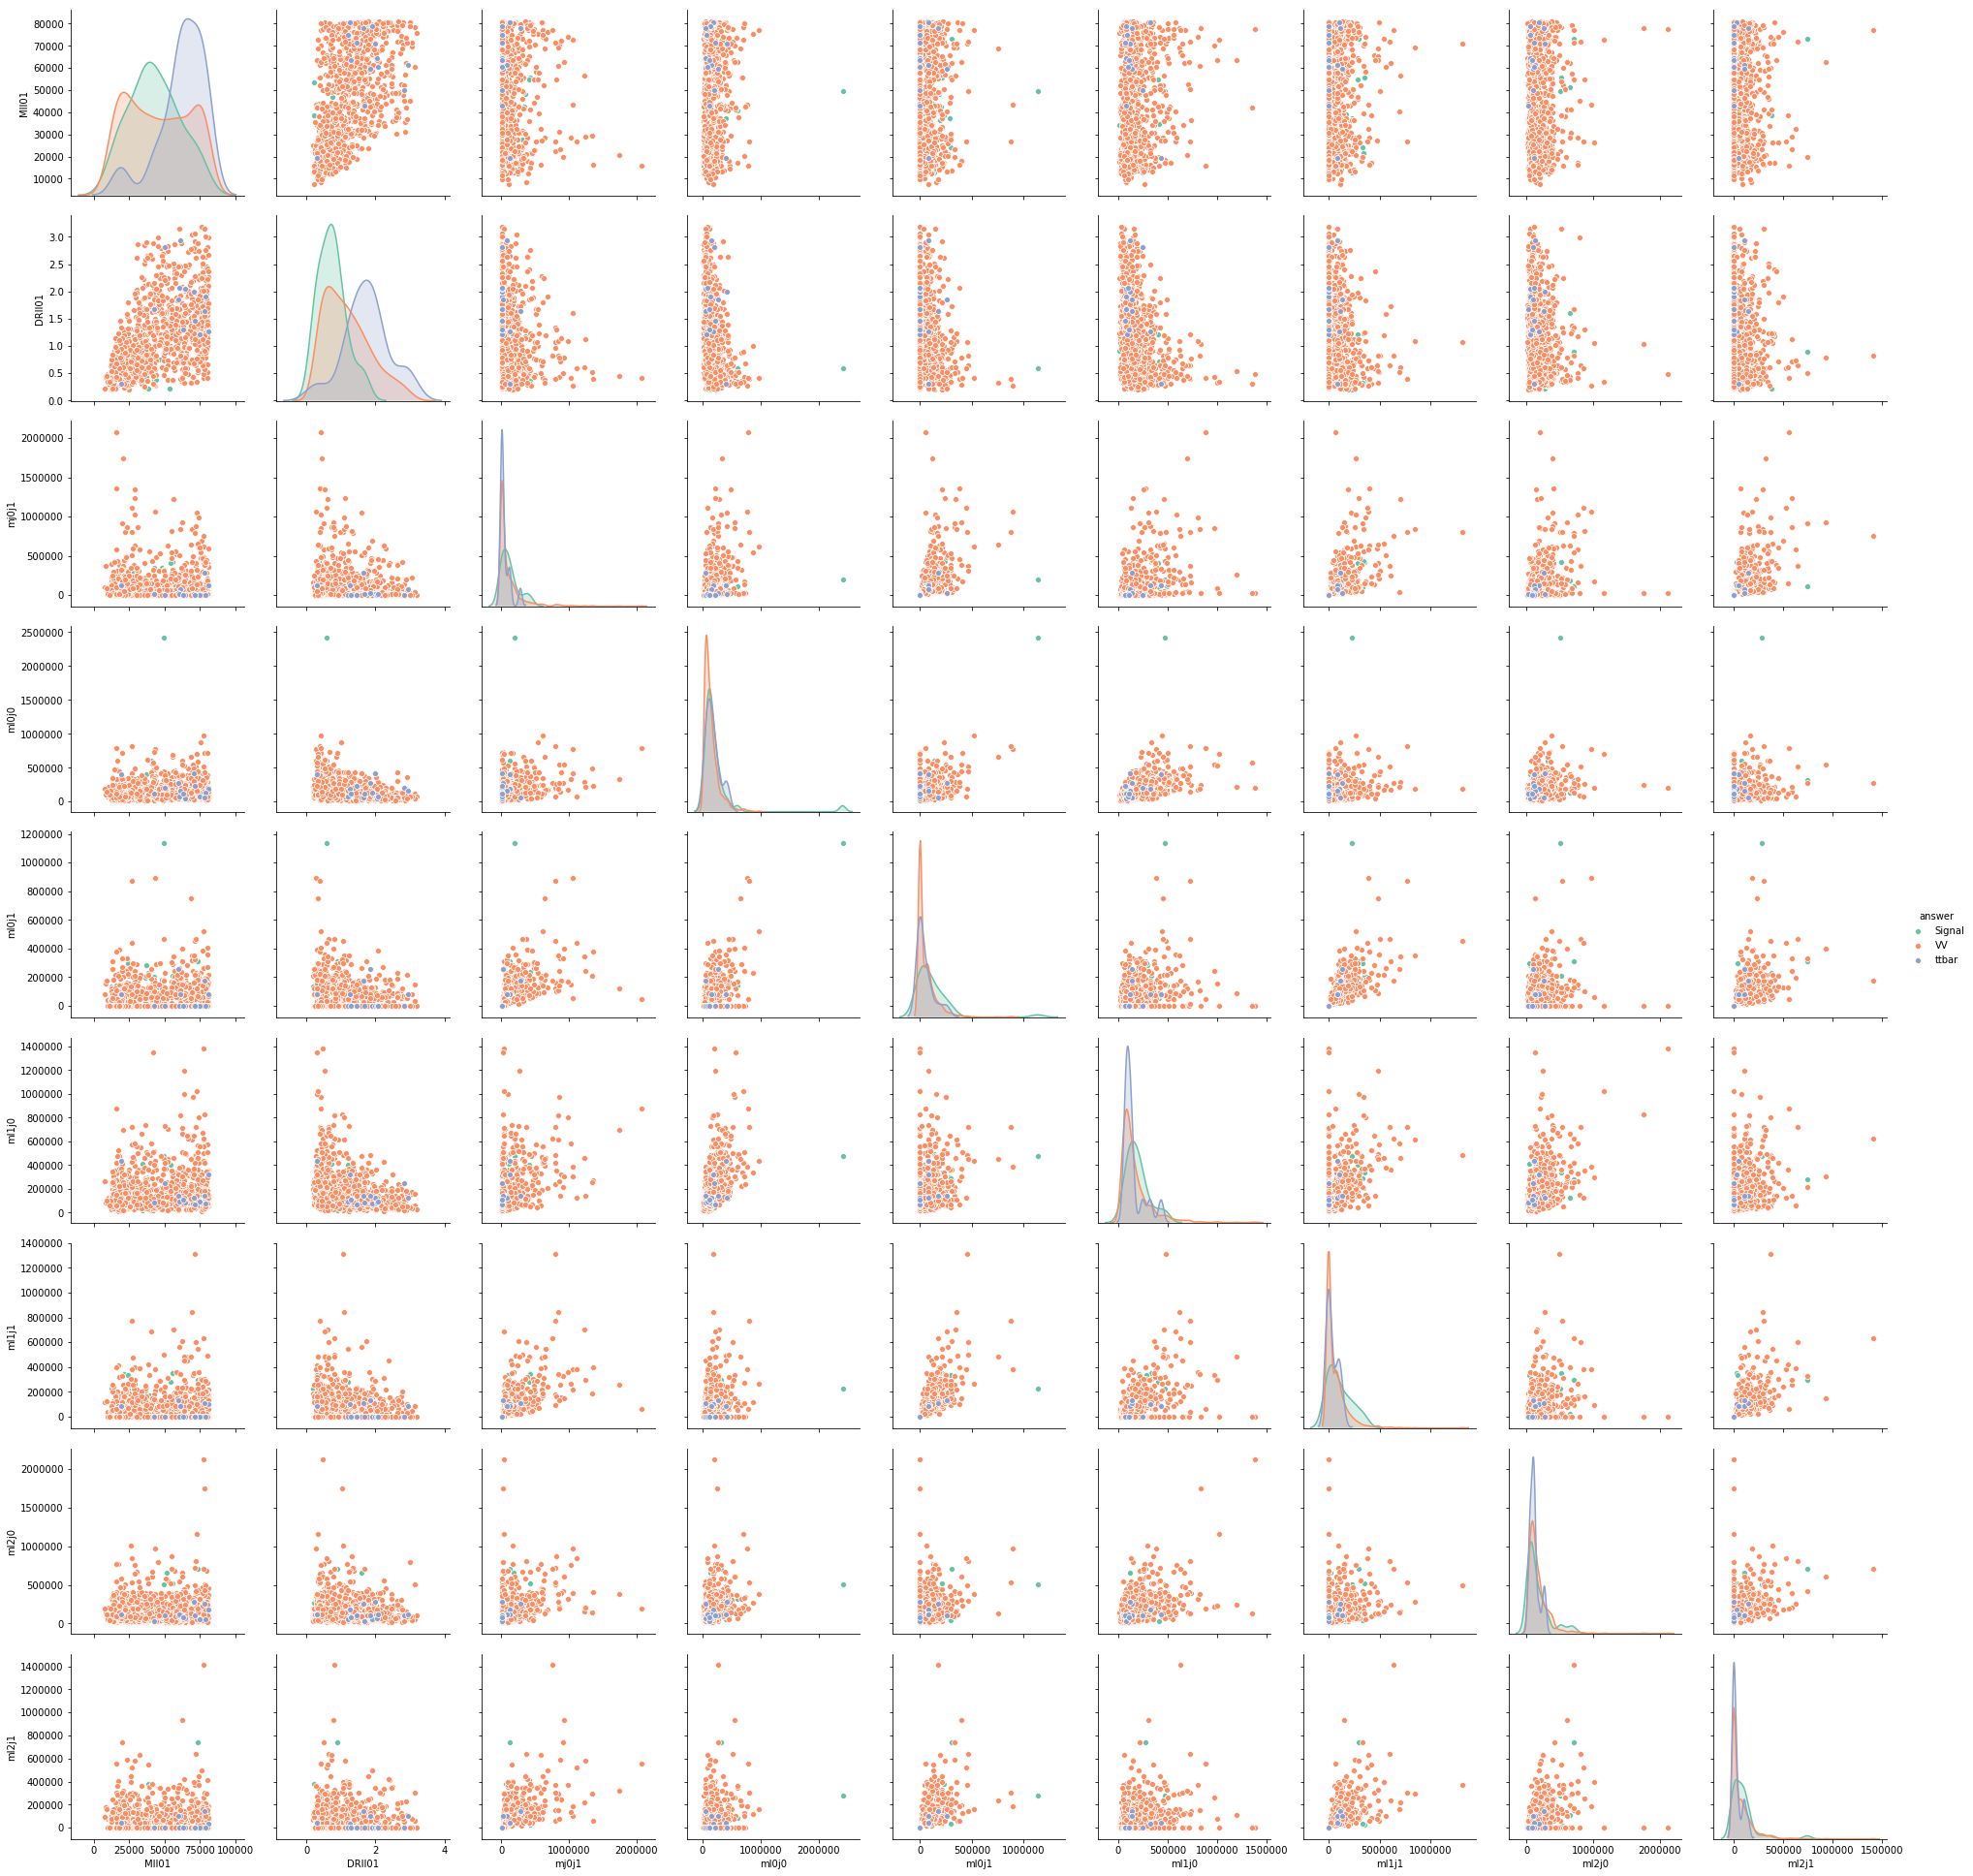

In [6]:
import seaborn as sns
# Seaborn is a nice package for data visualization - it has many pre-defined plotting functions and looks pretty

# Only keep some variables for training
variable_names = ['Mll01','DRll01','mj0j1','ml0j0','ml0j1','ml1j0','ml1j1','ml2j0','ml2j1']
#variable_names = branch_names

# Make a new column where the answer is a category with the appropriate name, for plotting
df['answer']='CH3T'
df.loc[y_df==0,'answer']='Signal'
df.loc[y_df==1,'answer']='ttbar'
df.loc[y_df==2,'answer']='VV'
df['answer'] = df['answer'].astype('category')

# Plot input distributions and visualize correlations; only look at a subset of events for scatter plotting
g = sns.pairplot(df.head(1000), vars=variable_names, hue='answer', palette="Set2", height=3) # Diagonal plots are smoothed using kernel density estimator; skip with diag_kind='hist'

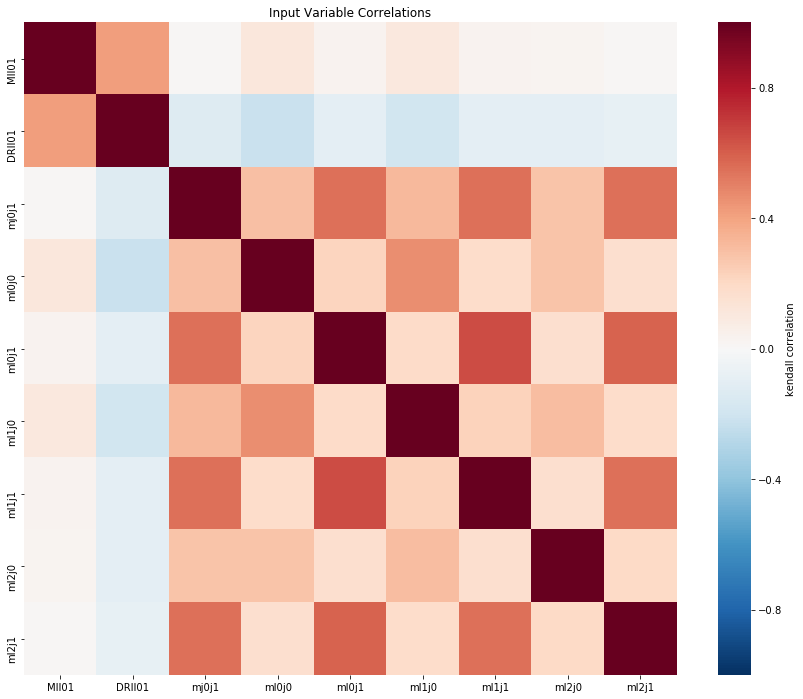

In [12]:
# Show correlation coefficients across variables
# Different correlation coefficients compared here: https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall
# Generically, Kendall only requires a monotonic relationship (not linear) and is more robust to outliers, as it only uses rank information (quantiles)
# Pearson includes a bit more information but assumes normal distributions and linear relationships
#method = 'pearson'
method = 'kendall'
correlations = df[variable_names].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (15,12))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reduce to only the variables we want to train on, use numpy array format
X_unscaled = np.array(df[variable_names])
Y = np.array(y_df)

# Split data into training and testing (70/30 split); shuffle order, just in case the indexing of the input data carries information
# Stratify option ensures train and test split preserves percentage of samples in each class; most important when one or more classes have low stats
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X_unscaled, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Perform initial transformations - StandardScaler sets mean of each feature to 0, std to 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled) # Use same scaling transformation on test and train data (do not pick a new mean, std)
X = scaler.transform(X_unscaled)

In [10]:


from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier

# Make the base classifier (single decision tree) - not yet trained, includes termination condition
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=10)
# Now combine a bunch of decision trees; number set by n_estimators. 
# The specific way samples are re-weighted is controlled by the AdaBoost algorithm
BDT = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')

# Train the BDT! One line, very fast
model = BDT.fit(x_train_unscaled, y_train) # BDT looks at each feature independently, so scaling is typically not necessary



ValueError: color kwarg must have one color per dataset

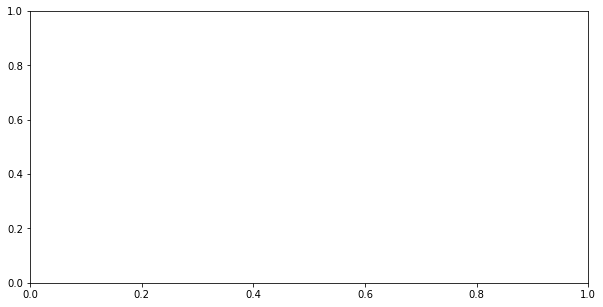

In [11]:


# Evaluate the BDT on the test (and train) data
y_pred_test = model.decision_function(x_test_unscaled)
y_pred_DD_train = model.decision_function(x_train_unscaled[y_train==1])
y_pred_DD_test = model.decision_function(x_test_unscaled[y_test==1])
y_pred_ch3t_train = model.decision_function(x_train_unscaled[y_train==0])
y_pred_ch3t_test = model.decision_function(x_test_unscaled[y_test==0])

n_bins=50
hist_range=(-1.0,1.0)
DD_color = sns.color_palette("Set2")[1]
CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,5))
plt.hist(y_pred_DD_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=DD_color,label="Train, DD")
counts,bin_edges = np.histogram(y_pred_DD_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=DD_color,label="Test, DD")

plt.hist(y_pred_ch3t_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=CH3T_color,label="Train, CH3T")
counts,bin_edges = np.histogram(y_pred_ch3t_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=CH3T_color,label="Test, CH3T")

plt.legend()
plt.xlabel('BDT output')
plt.show()



In [13]:
#Hyper parameter optimization
#https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        #'n_estimators': 100,
        'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
        'objective':hp.choice('objective',['multi:softprob','multi:softmax']),
        #'objective':hp.choice('objective',['binary:logistic','binary:hinge']),
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(num_class=3,
                    objective= space['objective'],
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),tree_method='gpu_hist')
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,eval_metric="merror",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

NameError: name 'clf_opt' is not defined